In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from functools import partial
from scipy.optimize import minimize, fsolve
import tqdm
import yfinance as yf
import yahoo_fin.options as ops

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [116]:
import exact_methods as exm
import characteristics_functions as chf
import monte_carlo_methods as mcm

In [117]:
expiration_dates = ops.get_expiration_dates("aapl")

In [118]:
expiration_dates

['March 18, 2022',
 'March 25, 2022',
 'April 1, 2022',
 'April 8, 2022',
 'April 14, 2022',
 'April 22, 2022',
 'April 29, 2022',
 'May 20, 2022',
 'June 17, 2022',
 'July 15, 2022',
 'August 19, 2022',
 'September 16, 2022',
 'October 21, 2022',
 'November 18, 2022',
 'January 20, 2023',
 'March 17, 2023',
 'June 16, 2023',
 'September 15, 2023',
 'January 19, 2024',
 'June 21, 2024']

In [119]:
s0_apple = 150.62 #15.03.2022

In [120]:
apple_option_calls = ops.get_calls("AAPL", 'April 1, 2022')

In [121]:
apple_option_calls.to_csv('apple_option_call_april_01_2022.csv')

In [122]:
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [123]:
numberPaths = 200
N = 500
T = 1
r = 0.05
rho1 = 0.01

type_option = 'c'

In [133]:
# v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2

def error_heston_stoch_corr_AES(x, prices, K, s0):
    paths = mcm.heston_stoch_corr_AES(numberPaths, N, s0, x[0], T, x[1], x[2], x[3], x[4], r, x[5], x[6], x[7], rho1, x[8])[1]
    
    price_calib = mcm.optionPriceMCGeneral(type_option, paths, K, T, r)
    
    return np.mean((price_calib - prices)**2)

In [137]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 0.1), (0, 5), (0, 1), (0.01, 0.1), (-0.9, 0.9), (3, 5), (0.01, 1), (0.01, 0.5), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple), bounds=bounds, tol=1e-10, options={"maxiter": 2000})
params_heston_AES

      fun: 3.29361826690343
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.40341953e+07,  1.15011260e+08, -1.92875307e+07,  7.55835184e+07,
        2.70250256e+08,  7.99745670e+07,  1.15605279e+08,  3.70475369e+08,
        2.06516904e+08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 320
      nit: 3
     njev: 32
   status: 0
  success: True
        x: array([ 0.04000003,  2.00000156,  0.20000042,  0.01999999, -0.80000009,
        3.99999946,  0.20000042,  0.39999979,  0.01999995])

In [138]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [139]:
paths_heston_AES = mcm.heston_stoch_corr_AES(numberPaths, N, s0_apple, v0, T, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]

In [140]:
option_heston_AES = mcm.optionPriceMCGeneral(type_option, paths_heston_AES, apple_strikes, T, r)

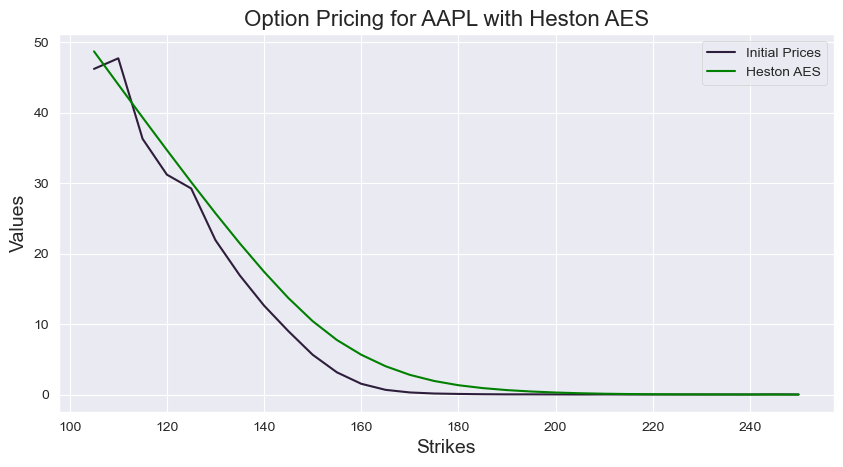

In [141]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(apple_strikes, apple_market_price, label='Initial Prices')
plt.plot(apple_strikes, option_heston_AES, color='green', label='Heston AES')
        
plt.title('Option Pricing for AAPL with Heston AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [142]:
tsla = ops.get_calls("TSLA", 'April 1, 2022')

In [143]:
# tsla.to_csv('tsla_option_call_april_01_2022.csv')

In [144]:
s0_tsla = 766.37 #15.03.2022

In [145]:
tsla_strikes = tsla.loc[:, 'Strike']
tsla_market_price = tsla.loc[:, 'Last Price']

In [146]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 0.1), (0, 5), (0, 1), (0.01, 0.1), (-0.9, 0.9), (1, 5), (0.01, 1), (0.01, 0.5), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(tsla_market_price, tsla_strikes, s0_tsla), bounds=bounds, tol=1e-10, options={"maxiter": 2000})
params_heston_AES

/Users/kirillzakharov/Desktop/Stochastic Calculus/monte_carlo_methods.py:173: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1- (rho[:, t])**2 - ((rho2-rho1*rho[:, t])/np.sqrt(1-rho1**2))**2)*np.sqrt(V[:, t]) * np.sqrt(dt) * Zx[:, t]


      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.08849976e+09, -1.18369863e+09, -2.41803836e+08,  6.74875327e+07,
       -1.54727989e+08,  2.54306652e+08,  8.80387514e+08, -1.19259934e+09,
        1.14242293e+09])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 20
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 0.04,  2.  ,  0.2 ,  0.02, -0.8 ,  4.  ,  0.2 ,  0.4 ,  0.02])

In [147]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [148]:
paths_heston_AES = mcm.heston_stoch_corr_AES(numberPaths, N, s0_tsla, v0, T, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]

In [149]:
option_heston_AES = mcm.optionPriceMCGeneral(type_option, paths_heston_AES, tsla_strikes, T, r)

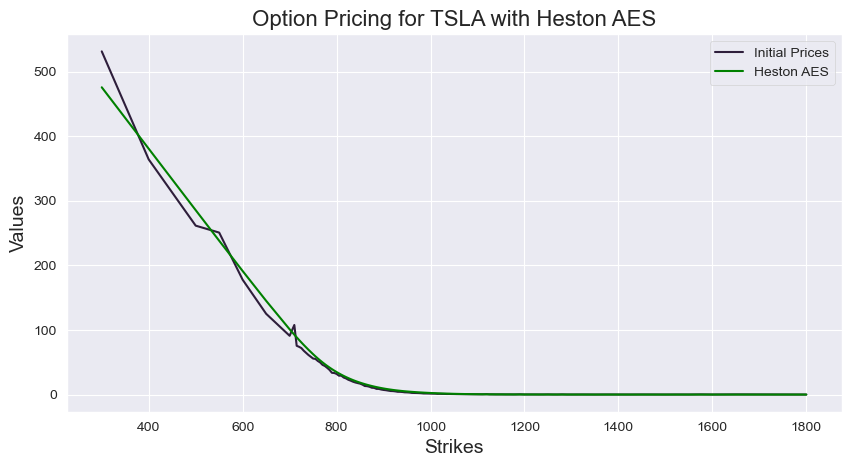

In [151]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(tsla_strikes, tsla_market_price, label='Initial Prices')
plt.plot(tsla_strikes, option_heston_AES, color='green', label='Heston AES')
        
plt.title('Option Pricing for TSLA with Heston AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()